# Text Classification with Bert

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

# Preliminaries
import re

from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')
print("Using device: {}"
      "\n".format(str(device)))

Using device: mps



# EDA of Dataset

In [3]:
# Select the dataset for the analysis
df = pd.read_csv("all-data-v1.csv")

# Show the data
df.head()

,sentiment,text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [4]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["sentiment"].value_counts())
print(40*'-')
nr_categories = len(df["sentiment"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of news: 4846
----------------------------------------
Split by category:
1    2879
2    1363
0     604
Name: sentiment, dtype: int64
----------------------------------------
Number of categories: 3


# Preprocessing

In [5]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
stopWords = stopwords.words('english') # from NLTK

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanpua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Defining a Function to clean up the reviews 
def utils_preprocess_text(text, 
                          flg_stemm=False, 
                          flg_lemm=False, 
                          lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    # The function is not optimized for speed but split into various steps for pedagogical purpose
    
#     text = str(text)
    text = str(text).lower()
    text = re.sub("[!?.,@#$%\^*()';:/~<>]", '', text) # remove punctuations
    text = text.replace('-', ' ') # replace 
    text = text.replace("&", 'and') # replace
    text = text.strip()

    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
# Let's apply this function to the whole corpus
df["text_clean"] = df["text"].apply(
    lambda x: utils_preprocess_text(x, 
                                    flg_stemm=False, 
                                    flg_lemm=False, 
                                    lst_stopwords=stopWords
                                   ))

# Let's look at the output
df.head()

,sentiment,text,text_clean
0,1,"According to Gran , the company has no plans t...",according gran company plans move production r...
1,1,Technopolis plans to develop in stages an area...,technopolis plans develop stages area less 100...
2,0,The international electronic industry company ...,international electronic industry company elco...
3,2,With the new production plant the company woul...,new production plant company would increase ca...
4,2,According to the company 's updated strategy f...,according company updated strategy years 2009 ...


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load Data into DataLoader

In [9]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X,y):

        self.labels = [label for label in y]
        self.texts = [tokenizer(text, 
                                padding='max_length', 
                                max_length = 50, 
                                truncation=True,
                                return_tensors="pt"
                               ) 
                      for text in X]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [10]:
from sklearn.model_selection import train_test_split


# Renaming, Input -> X, Output -> y
X = df['text_clean']
y = df['sentiment']
# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=df['sentiment']
                                                   )

In [11]:
X_train

4744                      baltic countries sales fell 426
4153    finnish energy company fortum set new stricter...
2452    financial statements include consolidated fina...
1938    managing director comments `` net sales first ...
2183    russia accounted 9 lagardere magazine division...
                              ...                        
2538    depth expertise extends fields energy industry...
2899    finnish fibre based materials maker ahlstrom c...
3274    latest result included per share charges 5 cen...
3588    finnish silicon wafer technology company okmet...
3685    mr doring eaton since 1989 acted business unit...
Name: text_clean, Length: 3392, dtype: object

In [12]:
train, val = Dataset(X_train, y_train), Dataset(X_test, y_test)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=32)

In [13]:
print(train.__len__())
print(val.__len__())

3392
1454


#  Build Model

In [14]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [15]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model, optimizer):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


# Train Model

In [16]:
model = BertClassifier().to(device)
lr = 1e-5
optimizer = Adam(model.parameters(), lr=lr)
destination_folder = './output/bert'

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_dataloader,
          valid_loader = val_dataloader,
          num_epochs = 5,
          eval_every = len(train_dataloader) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        
        total_acc_train = 0
        total_loss_train = 0
        for train_input, train_label in train_dataloader:
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                
                total_acc_val = 0
                total_loss_val = 0
                
                with torch.no_grad():                    

                    # validation loop
                    for val_input, val_label in val_dataloader:

                        val_label = val_label.to(device)
                        mask = val_input['attention_mask'].to(device)
                        input_id = val_input['input_ids'].squeeze(1).to(device)

                        output = model(input_id, mask)

                        batch_loss = criterion(output, val_label.long())
                        total_loss_val += batch_loss.item()

                        acc = (output.argmax(dim=1) == val_label).sum().item()
                        total_acc_val += acc

                # evaluation
                average_train_loss = total_loss_train / eval_every
                average_valid_loss = total_loss_val / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


train(model=model, optimizer=optimizer, num_epochs =2)

Epoch [1/2], Step [53/212], Train Loss: 0.9785, Valid Loss: 0.8941
Model saved to ==> ./output/bert/model.pt
Model saved to ==> ./output/bert/metrics.pt
Epoch [1/2], Step [106/212], Train Loss: 1.8496, Valid Loss: 0.7707
Model saved to ==> ./output/bert/model.pt
Model saved to ==> ./output/bert/metrics.pt
Epoch [2/2], Step [159/212], Train Loss: 0.7454, Valid Loss: 0.6636
Model saved to ==> ./output/bert/model.pt
Model saved to ==> ./output/bert/metrics.pt
Epoch [2/2], Step [212/212], Train Loss: 1.3846, Valid Loss: 0.6182
Model saved to ==> ./output/bert/model.pt
Model saved to ==> ./output/bert/metrics.pt
Model saved to ==> ./output/bert/metrics.pt
Finished Training!


Model loaded from <== ./output/bert/metrics.pt


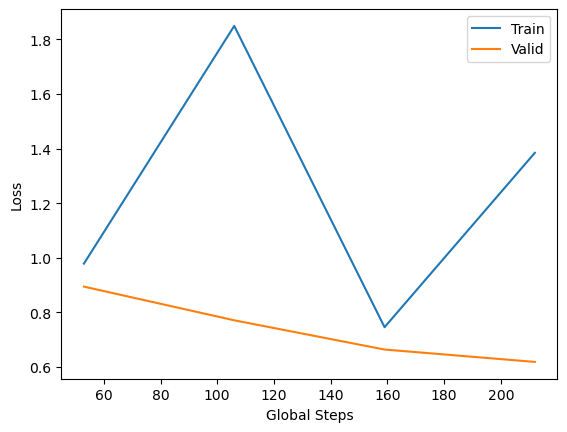

In [18]:

train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./output/bert/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.6626    0.5967    0.6279       181
           1     0.7818    0.9167    0.8439       864
           2     0.7698    0.5232    0.6230       409

    accuracy                         0.7662      1454
   macro avg     0.7381    0.6789    0.6983      1454
weighted avg     0.7636    0.7662    0.7549      1454



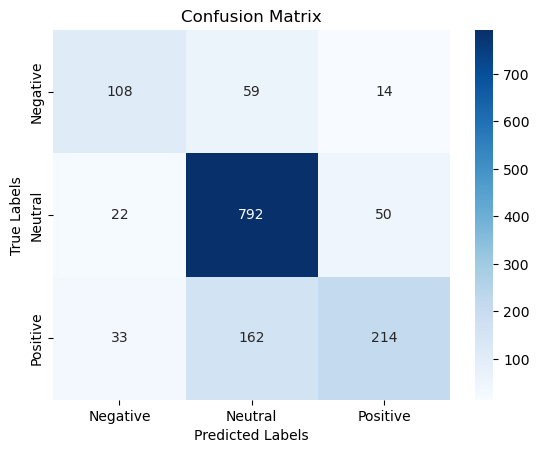

In [19]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for test_input,test_label in test_loader: 
            
            
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            output = output.argmax(dim=1)
            
            y_pred.extend(output.cpu().tolist())
            y_true.extend(test_label.cpu().tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
    
    
best_model = BertClassifier().to(device)
optimizer = Adam(best_model.parameters(), lr=lr)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, val_dataloader)

# Appendix

In [20]:
example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])


example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

tensor([[  101,  1045,  2097,  3422,  2033, 23065,  3892,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])
[CLS] i will watch memento tonight [SEP] [PAD] [PAD]
